In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("aug_train.csv")

In [3]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
# Checking for missing values
missing_values = df.isnull().sum()
missing_values_percentage = (missing_values / len(df)) * 100

# Combining missing value counts and their corresponding percentages
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_values_percentage})
missing_data[missing_data['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)

,Missing Values,Percentage (%)
company_type,6140,32.049274
company_size,5938,30.994885
gender,4508,23.530640
major_discipline,2813,14.683161
education_level,460,2.401086
last_new_job,423,2.207955
enrolled_university,386,2.014824
experience,65,0.339284


In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Handling missing values
# Imputing missing values for columns with fewer missing values using the most frequent value
frequent_imputer = SimpleImputer(strategy='most_frequent')
df['education_level'] = frequent_imputer.fit_transform(df[['education_level']]).ravel()
df['last_new_job'] = frequent_imputer.fit_transform(df[['last_new_job']]).ravel()
df['enrolled_university'] = frequent_imputer.fit_transform(df[['enrolled_university']]).ravel()
df['experience'] = frequent_imputer.fit_transform(df[['experience']]).ravel()

# Treating missing values as a separate category for columns with more missing values
for column in ['company_type', 'company_size', 'gender', 'major_discipline']:
    df[column].fillna('Unknown', inplace=True)

# Checking if there are any missing values left
missing_values_check = df.isnull().sum()
missing_values_check[missing_values_check > 0]


Series([], dtype: int64)

In [6]:
# Encoding categorical variables
# One-Hot Encoding for nominal variables
nominal_columns = ['city', 'gender', 'major_discipline', 'company_size', 'company_type', 'relevent_experience', 'enrolled_university']
df = pd.get_dummies(df, columns=nominal_columns, drop_first=True)

# Label Encoding for ordinal variables
label_encoder = LabelEncoder()

# Converting 'experience' to numerical values for label encoding
experience_map = {'<1': 0, '>20': 21}
df['experience'] = df['experience'].replace(experience_map)
df['experience'] = df['experience'].apply(lambda x: int(x) if str(x).isdigit() else 21)

# Converting 'last_new_job' to numerical values for label encoding
last_new_job_map = {'never': 0, '>4': 5}
df['last_new_job'] = df['last_new_job'].replace(last_new_job_map)
df['last_new_job'] = df['last_new_job'].apply(lambda x: int(x) if str(x).isdigit() else 5)

# Applying label encoding
ordinal_columns = ['education_level', 'experience', 'last_new_job']
df[ordinal_columns] = df[ordinal_columns].apply(label_encoder.fit_transform)

# Display the first few rows of the processed dataset
df.head()


,enrollee_id,city_development_index,education_level,experience,last_new_job,training_hours,target,city_city_10,city_city_100,city_city_101,...,company_size_Unknown,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_Unknown,relevent_experience_No relevent experience,enrolled_university_Part time course,enrolled_university_no_enrollment
0,8949,0.920,0,21,1,36,1.0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,29725,0.776,0,15,5,47,0.0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
2,11561,0.624,0,5,0,83,0.0,0,0,0,...,1,0,0,0,0,0,1,1,0,0
3,33241,0.789,0,0,0,52,1.0,0,0,0,...,1,0,0,0,0,1,0,1,0,1
4,666,0.767,2,21,4,8,0.0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


0.0    75.065247
1.0    24.934753
Name: target, dtype: float64


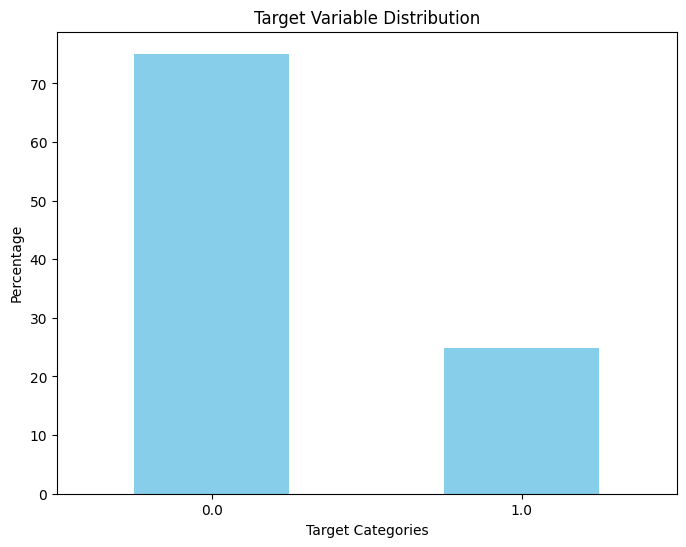

In [7]:
# Checking the distribution of the target variable
target_distribution = df['target'].value_counts(normalize=True) * 100
print(target_distribution)
# Assuming df is your DataFrame and 'target' is the column name
target_distribution = df['target'].value_counts(normalize=True) * 100

# Plotting the distribution
plt.figure(figsize=(8, 6))
target_distribution.plot(kind='bar', color='skyblue')
plt.title('Target Variable Distribution')
plt.xlabel('Target Categories')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()


1.0    50.0
0.0    50.0
Name: target, dtype: float64


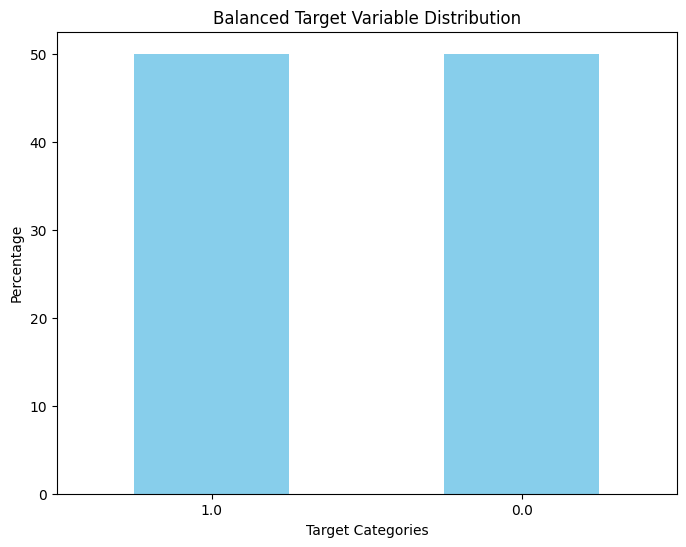

In [8]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Separating features and target variable
X = df.drop('target', axis=1)
y = df['target']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying SMOTE for handling imbalance
smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

# Checking the new distribution of the target variable
balanced_target_distribution = pd.Series(y_balanced).value_counts(normalize=True) * 100
print(balanced_target_distribution)


# Plotting the balanced distribution
plt.figure(figsize=(8, 6))
balanced_target_distribution.plot(kind='bar', color='skyblue')
plt.title('Balanced Target Variable Distribution')
plt.xlabel('Target Categories')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

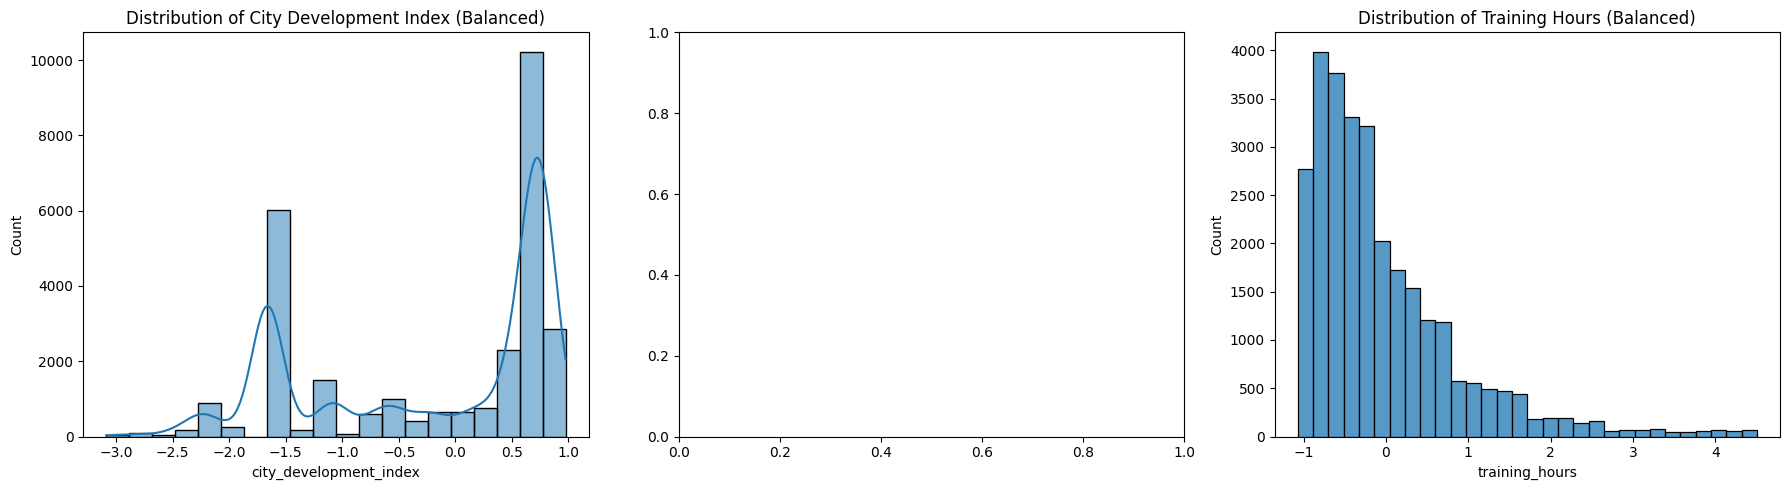

In [9]:
# Convert the balanced data back into a DataFrame
columns = X.columns  # column names
X_balanced_df = pd.DataFrame(X_balanced, columns=columns)
y_balanced_df = pd.Series(y_balanced, name='target')

# Combine features and target into a single DataFrame
balanced_df = pd.concat([X_balanced_df, y_balanced_df], axis=1)




# Feature Distributions: Analyzing the same key features post-balancing
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# City Development Index
sns.histplot(balanced_df['city_development_index'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of City Development Index (Balanced)')



# Training Hours
sns.histplot(balanced_df['training_hours'], bins=30, ax=axes[2])
axes[2].set_title('Distribution of Training Hours (Balanced)')

plt.tight_layout()
plt.show()



#SVM

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced_df, y_balanced_df, test_size=0.2, random_state=42)  # 80-20 split

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Initialize the SVM classifier
svm_classifier = SVC()

# Train the classifier
svm_classifier.fit(X_train_scaled, y_train)

In [19]:
# Predict on the test data
y_test_pred = svm_classifier.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", accuracy)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Accuracy: 0.7853293933599861
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.80      0.79      2877
         1.0       0.79      0.77      0.78      2876

    accuracy                           0.79      5753
   macro avg       0.79      0.79      0.79      5753
weighted avg       0.79      0.79      0.79      5753

